# Modeling Notebook - Positive/Negative/Neutral Classifier

In [33]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imblearnpipeline

import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from myFunctions import process_tweet_text_encode_to_ascii
from myFunctions import get_social_media_stopwords_list
from myFunctions import plot_word_cloud
from myFunctions import clean_tweet, tokenize_tweet, tokenize_lemmatize_tweet
from myFunctions import show_peformance_metrics, plot_pretty_cf

np.random.seed(42)

In [34]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding='unicode_escape')
print(pos_tweets.shape)

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding='unicode_escape')
print(neg_tweets.shape)

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding='unicode_escape')
print(neutral_tweets.shape)

all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(all_tweets.shape)


(2861, 7)
(544, 7)
(5293, 7)
(8698, 7)


## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [35]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets

positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


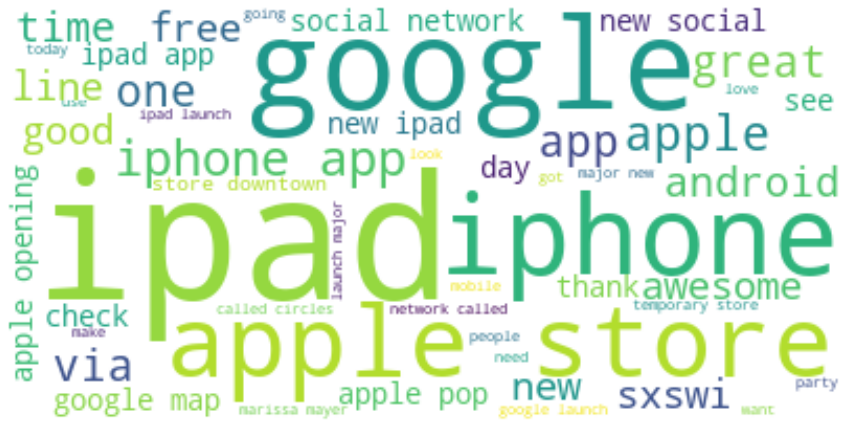

In [36]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 50, get_social_media_stopwords_list(), 'white')

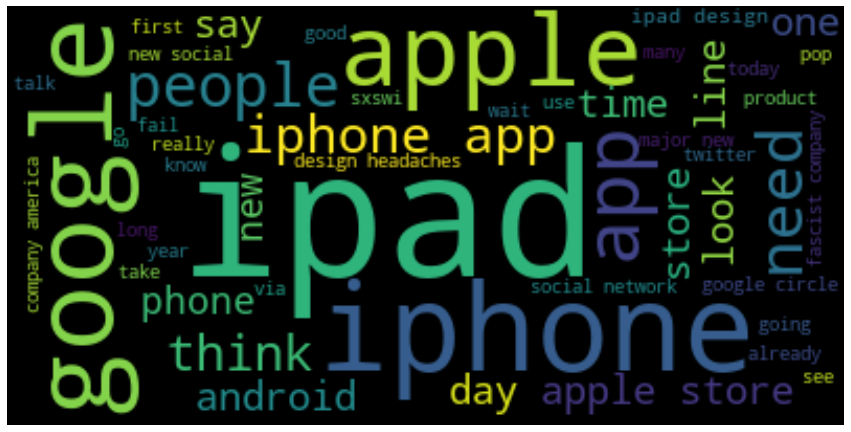

In [37]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 50, get_social_media_stopwords_list())

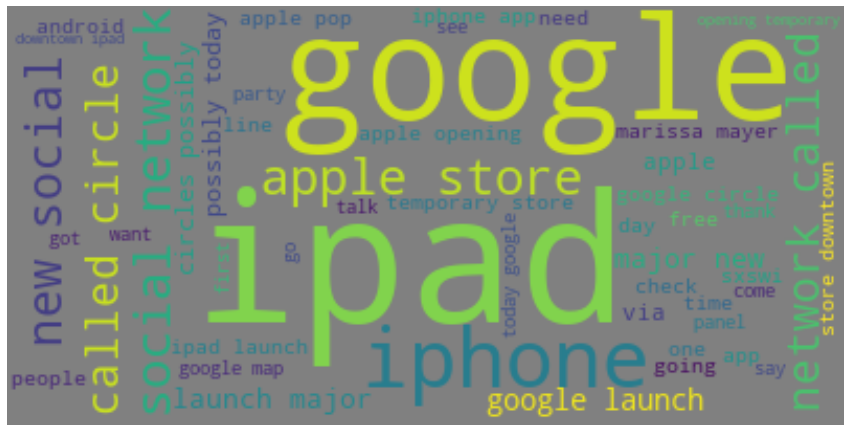

In [38]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 50, get_social_media_stopwords_list(), 'grey')

## Processing Done..let's get ready to build some Classification Models

In [39]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist?
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# TODO decide the best peformance measure, accuracy or precision. What makes sense from a business POV?

In [40]:
# Get TRAIN and TEST data and target and prep for processing steps
corpus = all_tweets['tweet_text'].tolist()
labels = all_tweets['sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, random_state=42)

In [41]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
# Use tokenzer for tweets and the customized stopwords list

tfidvectorizer = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet, 
                                        stop_words=get_social_media_stopwords_list(), 
                                        strip_accents='ascii',
                                        decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train = tfidvectorizer.fit_transform(X_train)
# Creat a vectorized version of the TEST data
tf_idf_data_test = tfidvectorizer.transform(X_test)

In [42]:
# TF-IDF - Let's check out the vocab for the ENTIRE corpus of Pos/Neg/Neutral Tweets...Train and Test
print(len(tfidvectorizer.vocabulary_.keys()))

8544


In [43]:
# Let's see what terms were important
# print idf values 
df_idf = pd.DataFrame(tfidvectorizer.idf_, index=tfidvectorizer.get_feature_names(),columns=["idf_weights"]) 
 
df_idf.sort_values(by=['idf_weights'], ascending=False)[:5]

,idf_weights
##apple_store,9.154644
impedimenta,9.154644
impacted,9.154644
immediate,9.154644
imitation,9.154644


## Models

In [44]:
# Try MultinomialNB
nb_classifier = Pipeline([  ('tfidf_vec', tfidvectorizer),
                            ('clf', MultinomialNB()) ])

nb_classifier.fit(X_train, y_train)

nb_classifier_train_predictions = nb_classifier.predict(X_train)
nb_classifier_test_predictions = nb_classifier.predict(X_test)

In [45]:
show_peformance_metrics(y_train, nb_classifier_train_predictions, X_test, y_test, nb_classifier_test_predictions, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.7542 		 Testing Accuracy: 0.6626
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       115
     Neutral       0.65      0.95      0.78      1040
    Positive       0.73      0.27      0.40       585

    accuracy                           0.66      1740
   macro avg       0.46      0.41      0.39      1740
weighted avg       0.64      0.66      0.60      1740

--------------------------------------------------------------------------


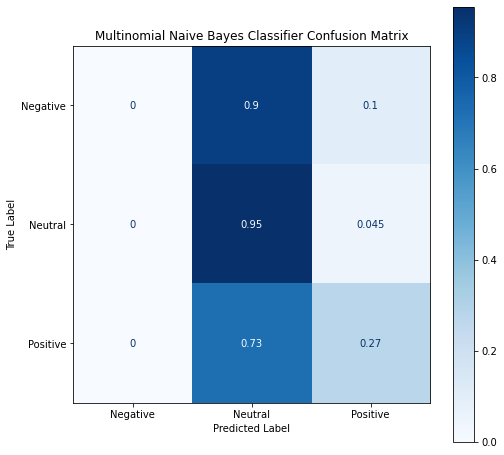

In [46]:
plot_pretty_cf(nb_classifier, X_test, y_test, title='Multinomial Naive Bayes Classifier Confusion Matrix')

In [47]:
# Try RandomForest
rf_classifier = Pipeline([  ('tfidf_vec', tfidvectorizer),
                            ('clf', RandomForestClassifier(n_estimators=100) )])

rf_classifier.fit(X_train, y_train)

rf_classifier_train_predictions = rf_classifier.predict(X_train)
rf_classifier_test_predictions = rf_classifier.predict(X_test)

In [48]:
show_peformance_metrics(y_train, rf_classifier_train_predictions, X_test, y_test, rf_classifier_test_predictions, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9609 		 Testing Accuracy: 0.7011
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.72      0.25      0.37       115
     Neutral       0.71      0.88      0.79      1040
    Positive       0.68      0.47      0.55       585

    accuracy                           0.70      1740
   macro avg       0.70      0.53      0.57      1740
weighted avg       0.70      0.70      0.68      1740

--------------------------------------------------------------------------


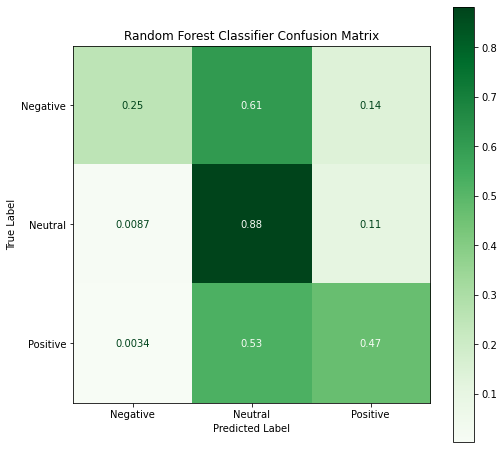

In [49]:
plot_pretty_cf(rf_classifier, X_test, y_test, cmap='Greens', title='Random Forest Classifier Confusion Matrix')

In [53]:
## Try LinearSVC
svc_clf = Pipeline([ ('tfidf_vec', tfidvectorizer),
                     ('clf', LinearSVC())  ])

svc_clf.fit(X_train, y_train)

svc_train_predictions = svc_clf.predict(X_train)
svc_test_predictions = svc_clf.predict(X_test)

In [54]:
show_peformance_metrics(y_train, svc_train_predictions, X_test, y_test, svc_test_predictions, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9198 		 Testing Accuracy: 0.6897
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.48      0.26      0.34       115
     Neutral       0.73      0.81      0.77      1040
    Positive       0.62      0.56      0.59       585

    accuracy                           0.69      1740
   macro avg       0.61      0.54      0.57      1740
weighted avg       0.68      0.69      0.68      1740

--------------------------------------------------------------------------


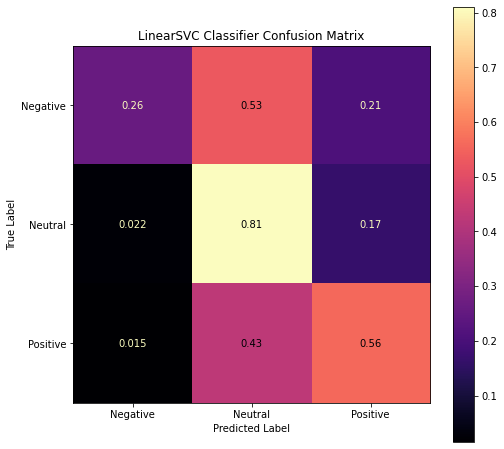

In [55]:
plot_pretty_cf(svc_clf, X_test, y_test, cmap='magma', title='LinearSVC Classifier Confusion Matrix')

## Let's try to address the class imbalance issues.

The corpus used to train this classifier has three classes, Neutral (60.9% of tweets), Positive (32.9% of tweets), and Negative (6.3% of tweets). The Positive and Negative classes are under-represented (especially Negative).

A quick (and basic) way to address class imbalance is to *oversample the under-represented class*. 

"Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.  Random oversampling can be used for two-class (binary) classification problems and multi-class classification problems with one or more majority or minority classes.

Importantly, the change to the class distribution is only applied to the training dataset. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model."

 More details [here] (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) 

In [56]:
# Create an imblearn Pipeline to apply the RandomOverSampler to our minority classes, Positive and Negative
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=7)

In [57]:
# imblearn Pipeline with MultinomialNB
nb_rus_clf = Pipeline([ ('tfidf_vec', tfidvectorizer),
                        ('clf', MultinomialNB()) ])

nb_rus_clf.fit(X_train, y_train)

nb_rus_y_pred = nb_rus_clf.predict(X_test)
nb_rus_y_train_pred = nb_rus_clf.predict(X_train)

In [58]:
show_peformance_metrics(y_train, nb_rus_y_train_pred, X_test, y_test, nb_rus_y_pred, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.7542 		 Testing Accuracy: 0.6626
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       115
     Neutral       0.65      0.95      0.78      1040
    Positive       0.73      0.27      0.40       585

    accuracy                           0.66      1740
   macro avg       0.46      0.41      0.39      1740
weighted avg       0.64      0.66      0.60      1740

--------------------------------------------------------------------------


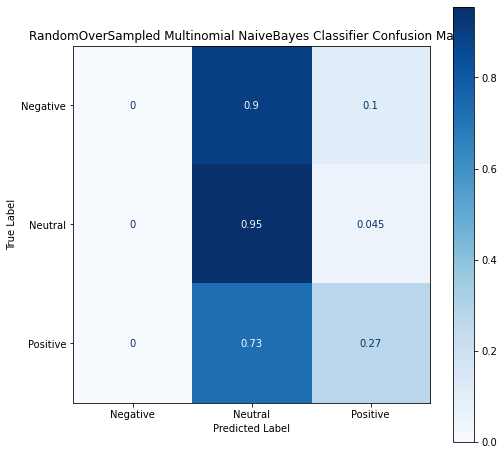

In [59]:
plot_pretty_cf(nb_rus_clf, X_test, y_test, cmap='Blues', title='RandomOverSampled Multinomial NaiveBayes Classifier Confusion Matrix')

In [60]:
# imblearn Pipeline with RandomForest
rt_rus_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer), 
                                        ('rus', oversampler),
                                        ('clf', RandomForestClassifier(n_estimators=100) )])

rt_rus_clf = rt_rus_clf.fit(X_train, y_train)

rt_rus_y_pred = rt_rus_clf.predict(X_test)
rt_rus_y_train_pred = rt_rus_clf.predict(X_train)

In [61]:
show_peformance_metrics(y_train, rt_rus_y_train_pred, X_test, y_test, rt_rus_y_pred, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9588 		 Testing Accuracy: 0.6897
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.27      0.37       115
     Neutral       0.72      0.82      0.77      1040
    Positive       0.62      0.55      0.58       585

    accuracy                           0.69      1740
   macro avg       0.65      0.54      0.57      1740
weighted avg       0.68      0.69      0.68      1740

--------------------------------------------------------------------------


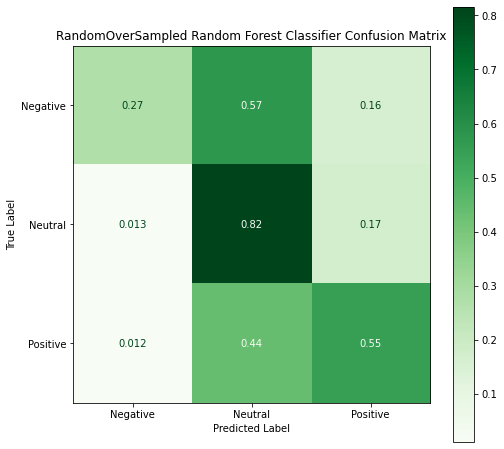

In [62]:
plot_pretty_cf(rt_rus_clf, X_test, y_test, cmap='Greens', title='RandomOverSampled Random Forest Classifier Confusion Matrix')

In [63]:
# imblearn Pipeline with MultinomialNB
svc_rus_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer), 
                                        ('rus', oversampler),
                                        ('clf', LinearSVC() )])

svc_rus_clf = svc_rus_clf.fit(X_train, y_train)

svc_rus_y_pred = svc_rus_clf.predict(X_test)
svc_rus_y_train_pred = svc_rus_clf.predict(X_train)

In [64]:
show_peformance_metrics(y_train, svc_rus_y_train_pred, X_test, y_test, svc_rus_y_pred, ['Negative', 'Neutral', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9199 		 Testing Accuracy: 0.6672
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.38      0.42      0.40       115
     Neutral       0.76      0.73      0.74      1040
    Positive       0.58      0.61      0.59       585

    accuracy                           0.67      1740
   macro avg       0.57      0.58      0.58      1740
weighted avg       0.67      0.67      0.67      1740

--------------------------------------------------------------------------


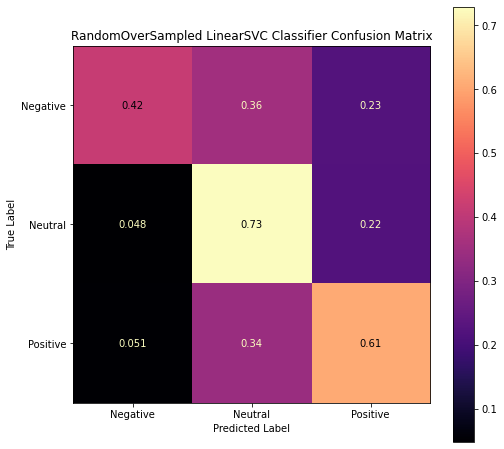

In [65]:
plot_pretty_cf(svc_rus_clf, X_test, y_test, cmap='magma', title='RandomOverSampled LinearSVC Classifier Confusion Matrix')